In [1]:
using AutoRisk
using AutoViz
using CommandLineFlags
using Interact
using Reel
Reel.set_output_type("gif");
include("../collection/collect_heuristic_dataset.jl");

In [2]:
# extract config from dataset
dataset_filepath = "../../data/datasets/may/heursitc_single_lane_30_sec_timestep.h5"
flags = h5readattr(dataset_filepath, "risk")
fixup_types!(flags)
flags["num_monte_carlo_runs"] = 1
col = build_dataset_collector("", flags);

In [3]:
# set config manually - I'd say if you're not sure, prob don't change or run this
# include("../collection/heuristic_dataset_config.jl")
# parse_flags!(FLAGS, [])
# FLAGS["num_monte_carlo_runs"] = 1
# FLAGS["prime_time"] = 10.
# FLAGS["sampling_time"] = 5.
# # FLAGS["roadway_type"] = "straight"
# # FLAGS["roadway_length"] = 10000.
# # FLAGS["roadway_length"] =  1000.
# # FLAGS["roadway_type"] =  "straight"
# # FLAGS["min_num_vehicles"] =  200
# # FLAGS["max_num_vehicles"] =  200
# # FLAGS["min_base_speed"] =  10.
# # FLAGS["max_base_speed"] =  10.
# # FLAGS["min_init_dist"] =  15.
# # FLAGS["overall_response_time"] = 0.2
# # FLAGS["lon_response_time"] = 0.2
# FLAGS["err_p_a_to_i"] =  0.05
# FLAGS["err_p_i_to_a"] =  0.3
# # FLAGS["min_init_dist"] =  15.
# # FLAGS["max_init_dist"] =  5.
# # FLAGS["num_lanes"] = 3
# # FLAGS["behavior_type"] = "heuristic"
# # FLAGS["driver_network_filepath"] = "../../data/policies/gail_gru.h5"
# FLAGS["extractor_type"] =  "multi"
# FLAGS["extract_road_lidar"] =  false
# col = build_dataset_collector("", FLAGS);


In [4]:
function Base.show(col::DatasetCollector, seed::Int; target_idx::Int = 1)
    if target_idx <= size(col.eval.targets, 1)
        # this is labeled collisions, but can be any target, selected by target_idx
        in_collision_veh_idxs = find(col.eval.targets[target_idx,:] .== 1.)
    else
        in_collision_veh_idxs = []
    end
    
    # if no collisions then still display the scene, but change car colors
    collisions_exist = in_collision_veh_idxs == [] ? false : true
    collision_color = collisions_exist ? colorant"red" : colorant"orange"
    if !collisions_exist
        in_collision_veh_idxs = sort(collect(values(col.eval.veh_id_to_idx)))
    end
    
    # prepare film for save case
    frames = Frames(MIME("image/png"), fps=10)
    
    # display the record
    @manipulate for follow_veh_idx in in_collision_veh_idxs,
                zoom in collect(1.:2:20.),
                i in 1:(col.eval.rec.nframes),
                save in [false, true],
                clear in [false, true]
        
        i -= 1
        # set camera
        follow_veh_id = -1
        if follow_veh_idx == 0
            cam = FitToContentCamera()
        else
            for (veh_id, veh_idx) in col.eval.veh_id_to_idx
                if veh_idx == follow_veh_idx
                    follow_veh_id = veh_id
                    break
                end
            end
            cam = AutoViz.CarFollowCamera{Int}(follow_veh_id, zoom)
        end

        # render scene
        idx = -(col.eval.rec.nframes - i) + 1
        carcolors = Dict{Int,Colorant}()
        for veh in col.eval.rec[idx]
            carcolors[veh.id] = veh.id == follow_veh_id ? collision_color : colorant"green"
        end
        mlane = 0
        if typeof(col.models[follow_veh_id]) == DelayedDriver
            mlane = col.models[follow_veh_id].driver.mlane
        elseif typeof(col.models[follow_veh_id]) == Tim2DDriver
            mlane = col.models[follow_veh_id].mlane
        else
            mlane = nothing
        end
        
        stats = follow_veh_id == -1 ? [] : [
            CarFollowingStatsOverlay(follow_veh_id, 2), 
            NeighborsOverlay(follow_veh_id, textparams = TextParams(x = 600, y_start=300))]
        
        if false && mlane != nothing && typeof(mlane) == MOBIL
            push!(stats, MOBILOverlay(follow_veh_id, mlane))
        end
        
        frame = render(col.eval.rec[idx], col.roadway, stats,
            cam = cam, car_colors = carcolors)
        push!(frames, frame)
        
        # to use the save, move around the slider above and collect some frames to write
        # then switch to save, then switch off save
        # this will write the frames, and then clear them
        if save
            filename = "seed_$(seed)_veh_id_$(follow_veh_idx)_target_$(target_idx)"
            write("../../data/visualizations/outputs/$(filename).gif", frames)
            frames = Frames(MIME("image/png"), fps=2)
        end
        
        # to clear frames without saving them set this to true then false
        if clear
            frames = Frames(MIME("image/png"), fps=10)
        end
        
        frame
    end

end

In [5]:
seed = 1
rand!(col, seed)
evaluate!(col.eval, col.scene, col.models, col.roadway, seed);

Interact.Options{:ToggleButtons,Int64}(13: "input-6" = 1 Int64 ,"follow_veh_idx",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",42=>"42",29=>"29",8=>"8",20=>"20",14=>"14"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(15: "input-7" = 1.0 Float64 ,"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"3.0"=>3.0,"5.0"=>5.0,"7.0"=>7.0,"9.0"=>9.0,"11.0"=>11.0,"13.0"=>13.0,"15.0"=>15.0,"17.0"=>17.0,"19.0"=>19.0…),Dict(7.0=>"7.0",9.0=>"9.0",13.0=>"13.0",3.0=>"3.0",19.0=>"19.0",17.0=>"17.0",11.0=>"11.0",5.0=>"5.0",15.0=>"15.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(17: "input-8" = 225 Int64 ,"i",225,"225",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(288=>"288",306=>"306",11=>"11",134=>"134",158=>"158",160=>"160",215=>"215",29=>"29",131=>"131",391=>"391"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(19: "input-9" = false Bool ,"save",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(21: "input-10" = false Bool ,"clear",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

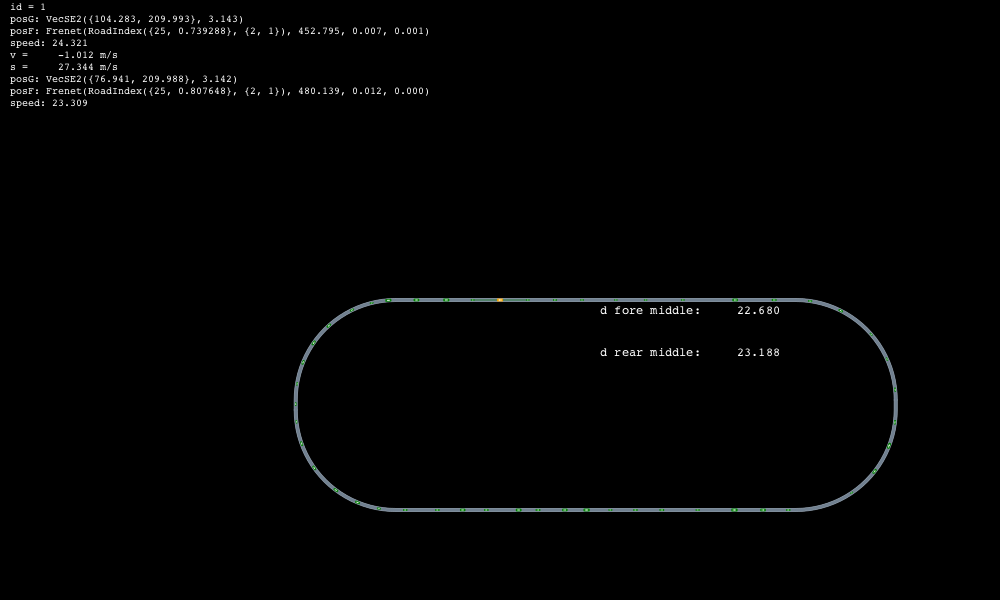

In [7]:
show(col, seed, target_idx = 4)

In [ ]:
println(col.models[2])

In [ ]:
println(mean(col.eval.agg_targets, 2))

In [ ]:
println(mean(col.eval.features, 3))